# Multi State Discrimination

In this tutorial we show how to set up an experiment to discriminate between the first $n$ energy states. The experiment will create $n$ circuits that prepare, respectively, the states $|0\rangle, \cdots, |n-1\rangle$. The measured data is then used to train a discriminator.

Here we will take $n=3$ and thus discriminate between $|0\rangle, |1\rangle$ and $|2\rangle$.

## Calibrate schedules

The first step is to calibrate the pulse schedules that take the energy level $|i\rangle$ to $|i+1\rangle$. These schedules will be later used to build the $n$ circuits for the experiment.

In [1]:
from qiskit import pulse

from qiskit_experiments.calibration_management import Calibrations
from qiskit_experiments.test.pulse_backend import SingleTransmonTestBackend

In [2]:
backend = SingleTransmonTestBackend(noise=False)

In [3]:
qubit = 0

In [4]:
# Calibrate schedule that takes the state |1> into |2>
cals = Calibrations.from_backend(backend)

anharm = backend.anharmonicity

d0 = pulse.DriveChannel(qubit)

pulse_x = backend.defaults().instruction_schedule_map.get('x', (qubit,)).instructions[0][1].pulse
amp_x = pulse_x.amp
dur_x = pulse_x.duration
sigma_x = pulse_x.sigma
beta_x = pulse_x.beta
with pulse.build(name='x12') as x12:
    pulse.shift_frequency(anharm, d0)
    pulse.play(pulse.Gaussian(dur_x, amp_x * backend.rabi_rate_12, sigma_x, beta_x), d0)
    pulse.shift_frequency(-anharm, d0)
    
cals.add_schedule(x12, qubits=qubit, num_qubits=1)

## Discriminator experiment

Now that the pulse schedules are calibrated we can build the multi state discriminator experiment. The calibrated schedules are used as an initialisation argument for the experiment.

In [5]:
from qiskit_experiments.library import MultiStateDiscrimination
exp_disc = MultiStateDiscrimination(qubit, n_states=3, backend=backend, schedules={'x12':cals.get_schedule('x12', qubit)})

The circuits preparing the different energy levels are of the form:

In [6]:
# circuit preparing |0>
exp_disc.circuits()[0].draw()

░ ┌─┐
   q: ─░─┤M├
       ░ └╥┘
meas: ════╩═

In [7]:
# circuit preparing |1>
exp_disc.circuits()[1].draw()

┌───┐ ░ ┌─┐
   q: ┤ X ├─░─┤M├
      └───┘ ░ └╥┘
meas: ═════════╩═

In [8]:
# circuit preparing |2>
exp_disc.circuits()[2].draw()

┌───┐┌─────┐ ░ ┌─┐
   q: ┤ X ├┤ x12 ├─░─┤M├
      └───┘└─────┘ ░ └╥┘
meas: ════════════════╩═

Next, we run the discrimination experiment:

In [9]:
exp_data_disc = exp_disc.run()

The analysis then returns the configuration of the trained discriminator and the fidelity of the discrimination.

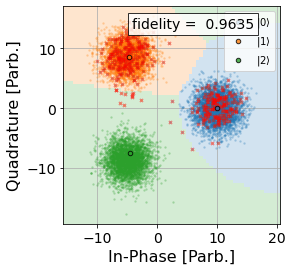

In [10]:
exp_data_disc.figure(0)

In [11]:
exp_data_disc.analysis_results('discriminator_config').value

{'params': {'priors': None,
  'reg_param': 0.0,
  'store_covariance': False,
  'tol': 0.0001},
 'attributes': {'coef_': None,
  'intercept_': None,
  'covariance_': None,
  'explained_variance_ratio_': None,
  'means_': array([[ 9.97015896e+15,  3.24225274e+13],
         [-4.67883021e+15,  8.50582453e+15],
         [-4.62340758e+15, -7.38806446e+15]]),
  'priors_': array([0.33333333, 0.33333333, 0.33333333]),
  'scalings_': [array([4.05713119e+30, 3.98763644e+30]),
   array([9.5786276e+30, 4.0244660e+30]),
   array([2.34770651e+31, 8.81597532e+30])],
  'xbar_': None,
  'classes_': array([0, 1, 2]),
  'n_features_in_': 2,
  'feature_names_in_': None,
  'rotations_': [array([[ 0.08926092, -0.99600828],
          [ 0.99600828,  0.08926092]]),
   array([[-0.87581508,  0.48264681],
          [ 0.48264681,  0.87581508]]),
   array([[-0.20156214,  0.97947573],
          [-0.97947573, -0.20156214]])]}}

In [12]:
exp_data_disc.analysis_results('fidelity').value

0.9635